## RFM Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly.express as px
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('float_format', '{:,.2f}'.format)

In [2]:
rfm_data= pd.read_csv('dataset/cleaned_online_data.csv')
rfm_data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
357673,578041,20846,ZINC HEART LATTICE T-LIGHT HOLDER,6,2011-11-22 14:23:00,1.25,"17,338.00",United Kingdom,7.50
288330,571438,20979,36 PENCILS TUBE RED RETROSPOT,16,2011-10-17 13:25:00,1.25,"15,066.00",United Kingdom,20.00
174205,559109,22231,JIGSAW TREE WITH BIRDHOUSE,1,2011-07-06 11:52:00,0.59,"15,021.00",United Kingdom,0.59
160084,557233,22631,CIRCUS PARADE LUNCH BOX,1,2011-06-17 14:44:00,1.95,"15,356.00",United Kingdom,1.95
218518,564301,22492,MINI PAINT SET VINTAGE,36,2011-08-24 11:54:00,0.65,"14,299.00",United Kingdom,23.40


### RFM Metrics
Calculate individual customers RFM value.

In [3]:
# calculate recency
Recency = pd.DataFrame(rfm_data.groupby('CustomerID')['InvoiceDate'].max().reset_index()) # each customers last purchase

Recency['InvoiceDate'] = pd.to_datetime(Recency['InvoiceDate']).dt.date
Recency['MaxDate'] =  Recency['InvoiceDate'].max() # max transaction date

Recency['Recency'] = (Recency['MaxDate'] - Recency['InvoiceDate']).dt.days + 1
Recency= Recency[['CustomerID', 'Recency']]
Recency.head()


,CustomerID,Recency
0,"12,346.00",326
1,"12,347.00",3
2,"12,348.00",76
3,"12,349.00",19
4,"12,350.00",311


In [4]:
# frequency
Frequency = pd.DataFrame(rfm_data.groupby('CustomerID')['InvoiceNo'].nunique(). reset_index())
Frequency.columns= ['fCustomerID', 'Frequency']
Frequency.head()

,fCustomerID,Frequency
0,"12,346.00",1
1,"12,347.00",7
2,"12,348.00",4
3,"12,349.00",1
4,"12,350.00",1


In [5]:
# monetary value
MonetaryValue = pd.DataFrame(rfm_data.groupby('CustomerID')['Amount'].nunique(). reset_index())
MonetaryValue.columns= ['mCustomerID', 'MonetaryValue']
MonetaryValue.head()

,mCustomerID,MonetaryValue
0,"12,346.00",1
1,"12,347.00",55
2,"12,348.00",16
3,"12,349.00",41
4,"12,350.00",9


In [6]:
#  combine the rfm tables
rfm = pd.concat([Recency, Frequency, MonetaryValue], axis=1)
rfm.drop(['fCustomerID', 'mCustomerID'], axis=1, inplace= True)
rfm.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,"12,346.00",326,1,1
1,"12,347.00",3,7,55
2,"12,348.00",76,4,16
3,"12,349.00",19,1,41
4,"12,350.00",311,1,9


In [7]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4339 non-null   float64
 1   Recency        4339 non-null   int64  
 2   Frequency      4339 non-null   int64  
 3   MonetaryValue  4339 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 135.7 KB


### RFM Analysis
1. Calculate RFM segment and score for each customers.

Here I calculated THE 3 customers behavior metrics which are recency, frequency and monetary values that was used to assign customers to RFM segment. We grouped RFM values using percentiles cut i.e quartiles using qcut function in pandas.

In [8]:
r_labels = range(4, 0, -1);
f_labels = range(1, 5);
m_labels = range(1, 5)

r_groups = pd.qcut(rfm['Recency'].rank(method='first'), q=4, labels=r_labels)
f_groups = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
m_groups = pd.qcut(rfm['MonetaryValue'].rank(method='first'), q=4, labels=m_labels)

# Create new columns for R.F.M
rfm_seg = rfm.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)

# concatenate RFM quartile values
rfm_seg['RfmSegment'] = rfm_seg['R'].astype(str) + rfm_seg['F'].astype(str) + rfm_seg['M'].astype(str)

# sum RFM quartile values to RFM_score
rfm_seg['RfmScore'] = rfm_seg[['R', 'F', 'M']].sum(axis=1)
rfm_seg.sample(5)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RfmSegment,RfmScore
2654,"15,965.00",18,4,67,4,3,4,434,11
3967,"17,770.00",199,5,23,1,4,3,143,8
1346,"14,174.00",34,1,19,3,1,2,312,6
1599,"14,522.00",25,4,14,3,3,2,332,8
2105,"15,218.00",11,11,74,4,4,4,444,12


2. Use RFM segment value to categorise users into group

Defining the RFM terminologies as;
* The more recent they purchase, the more responsive the customers are i.e recent purchase = high recency value. 
* The more frequently the customers buy, the more engaged and satisfied they are i.e high frequency = high f value.
* The more they spend, the higher their monetary value.

This variation and important of category varies depending on nature of the business.

Category Interpretation:

I categorize my customers based on putler.com website. Note use can use either the *RfmSegment* column or *RfmScore* column to segment.
* Champions	-: Bought recently, buy often and spend the most!	
* Loyal Customers -: Spend good money with us often. 
* Potential Loyalist -:	Recent customers, but spent a good amount and bought more than once.
* Recent Customers -:	Bought most recently, but not often.
* Promising -:	Recent shoppers, but haven’t spent much.
* Customers Needing Attention -: Above average recency, frequency and monetary values. 	
* Can’t Lose Them -: Made biggest purchases, and often. But haven’t returned for a long time. Need to bring them back!	
* Hibernating -: Last purchase was long back, low spenders and bought seldomly. Will lose them if not reactivated.
* Lost -:	Lowest recency, frequency and monetary scores (RFM score).


In [9]:
# define users rfm category, using the RfmSegment column
def users_cat(seg):
  if seg['RfmSegment'] == '444':
    return 'Champions'

  elif seg['RfmSegment'] == '111':
    return 'Lost'

  else:
    if seg['M'] == 4 & seg['F'] == 4: 
      return 'Loyal Customers'

    if  seg['M'] == 4 & seg['F'] >= 3 & seg['R'] == 1:
      return 'Cant Lose Them'

    if seg['R'] >= 3 & seg['F'] <= 2:
      return 'Recent Customers'
    
    if seg['R'] >= 3 & seg['M'] <= 2:
          return 'Promising'

    if seg['R'] >= 3 & seg['M'] >= 3 & seg['F'] >= 1 | seg['F'] <= 2:
      return 'Potential Loyalist'

    if seg['R'] >=2 & seg['M'] >= 2 & seg['F'] >= 2:
      return 'Customers Needing Attention'

    return 'Hibernating'

rfm_seg['RfmCat'] = rfm_seg.apply(users_cat, axis=1)
rfm_seg.sample(5)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RfmSegment,RfmScore,RfmCat
135,"12,516.00",78,2,15,2,2,2,222,6,Recent Customers
3302,"16,842.00",101,3,23,2,3,3,233,8,Customers Needing Attention
2004,"15,089.00",11,6,50,4,4,4,444,12,Champions
155,"12,540.00",20,17,107,3,4,4,344,11,Loyal Customers
2284,"15,456.00",284,3,37,1,3,3,133,7,Hibernating


In [10]:
# calculate the recency, frequency and monetary value mean, to see each category contribution
rfm_agg = rfm_seg.groupby(['RfmCat']).agg({'Recency': 'mean',
                                            'Frequency': 'mean',
                                            'MonetaryValue': ['mean', 'count']}).round(0)
rfm_agg.columns = rfm_agg.columns.droplevel()

rfm_agg.columns =['Recency mean', 'Frequency mean', 'MonetaryValue mean', 'counts']
rfm_agg['Percent'] = round((rfm_agg['counts']/ rfm_agg.counts.sum()) *100, 2)
rfm_agg = rfm_agg.reset_index()
rfm_agg

,RfmCat,Recency mean,Frequency mean,MonetaryValue mean,counts,Percent
0,Champions,8.00,16.00,90.00,428,9.86
1,Customers Needing Attention,44.00,3.00,32.00,340,7.84
2,Hibernating,229.00,2.00,21.00,302,6.96
3,Lost,268.00,1.00,6.00,307,7.08
4,Loyal Customers,50.00,9.00,71.00,276,6.36
5,Promising,100.00,3.00,29.00,827,19.06
6,Recent Customers,74.00,3.00,21.00,1859,42.84


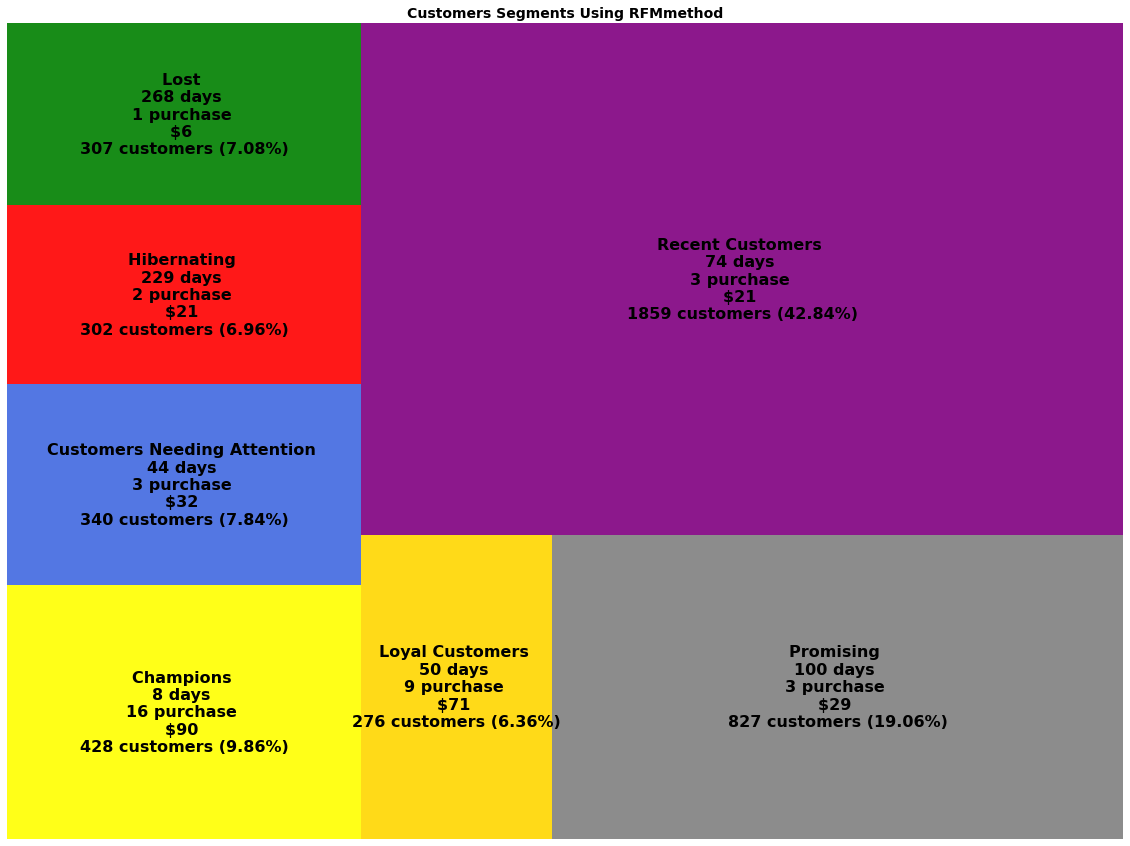

In [11]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 15)

colors_dict = {'Hibernating':'yellow','Promising':'royalblue',
               'Lost':'red', 'Champions':'green', 'Loyal Customers':'gold', 'Customers Needing Attention':'grey', 'Recent Customers': 'purple'}

squarify.plot(sizes = rfm_agg['counts'],
              text_kwargs = {'fontsize':16,'weight':'bold', 'fontname':'sans serif'},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} purchase \n${:.0f} \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.9 )


plt.title('Customers Segments Using RFMmethod', fontsize=14, fontweight = 'bold')
plt.axis('off')
plt.show()

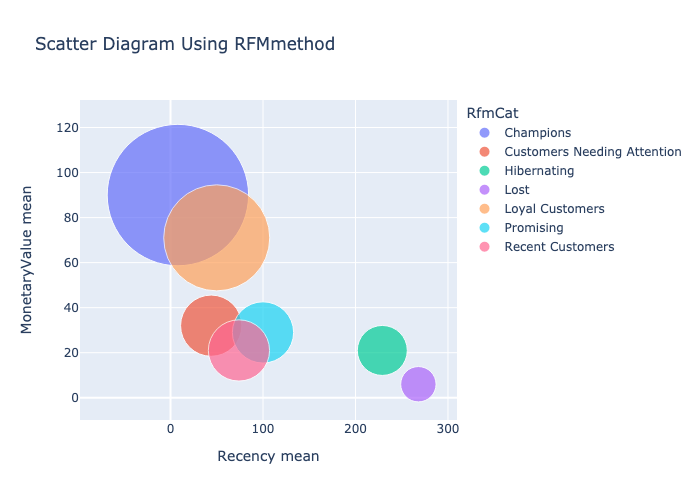

In [12]:
fig = px.scatter(rfm_agg, 
                 x='Recency mean', 
                 y='MonetaryValue mean', 
                 size='Frequency mean', 
                 color= 'RfmCat',
                 hover_name= 'RfmCat', 
                 size_max=100, 
                 title='Scatter Diagram Using RFMmethod')
fig.show(renderer="png")  # show this as a png due to github not able to render embedded html in notebooks

### In Conclusion
With the above analysis, we are able to answer the below questions.
* Who are your best customers?
* Which of your customers could contribute to your churn rate?
* Who has the potential to become valuable customers?
* Which of your customers can be retained?
* Which of your customers are most likely to respond to engagement campaigns?

##### Alternatively based on business needs, we can segment customers performance based on business definition as seen below.

In [13]:
# in the defined function, well performing users have 4 in all R.F.M --free to manipulate
def r_score(r_value):
    """low value ranks the least, i.e the 
    more recent a user transaction, the lower the rank"""
    
    if r_value <= 14:    # 2 weeks
        return 1
    elif r_value <= 31:   # 1 month
        return 2
    elif r_value <= 93:    # 3 month
        return 3
    else:
        return 4
    
    
def f_score(f_value):
    """the more a customer transact with the business, 
    the more their rank is closer to 1, the fewer the number of 
    times they have made transaction, the higher the rank"""
    
    if f_value <= 3:
        return 4
    elif f_value <= 18:
        return 3
    elif f_value <= 36:
        return 2
    else:
        return 1

    
def m_score(m_value):
    """the more the value contributed to the business, 
    the higher their rank to 1"""
    
    if m_value < 10:
        return 4
    elif m_value <= 100:
        return 3
    elif m_value <= 1000:
        return 2
    else:
        return 1